In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from models import BasicUNet
from training_functions import train_unet
from helper_functions import Evaluator, visualize_reconstructions, generate_images, calculate_frechet_distance

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


## Wczytanie danych

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_path = "./trafic_32"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

labels = dataset.classes
print("Number of labels:", len(dataset.classes))

Number of labels: 43


In [3]:
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=True, num_workers=4)

## Podstawowy model

In [4]:
def evaluate_unet(eval, model, orig_data, device, n_gen=100, n_steps=40):
    with torch.no_grad():
        fixed_noise = torch.randn(n_gen, 3, 32, 32).to(device)
        tmp = model(fixed_noise)
        for _ in range(n_steps):
            generations = model(tmp)
            tmp = generations
        dist_orig_data = eval.get_features(orig_data.to(device)).cpu()
        dist_gen = eval.get_features(generations.to(device)).cpu()
        return calculate_frechet_distance(dist_orig_data.numpy(), dist_gen.numpy())
    
image_dim = 3*32*32
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [5]:
net = BasicUNet(in_channels=3, out_channels=3).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [6]:
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
loss_hist, val_eval_hist = train_unet(net, train_loader, val_set[0], opt, loss_fn, evaluate_unet, evaluator)

  0%|          | 0/10 [00:00<?, ?it/s]/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/scipy/linalg/_matfuncs_sqrtm.py:205: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
100%|██████████| 10/10 [03:30<00:00, 21.10s/it]


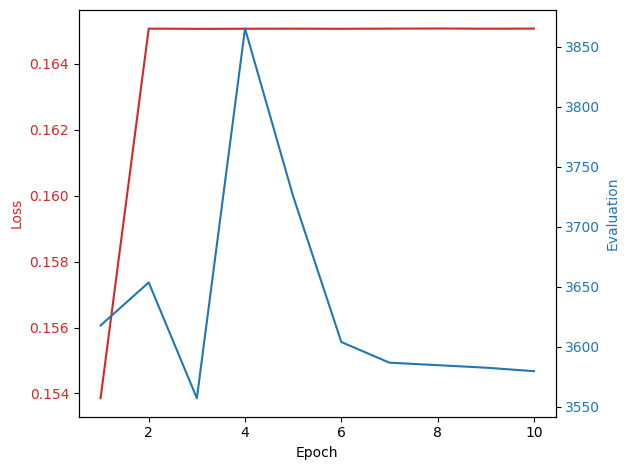

In [7]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 11)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Evaluation', color=color)
ax2.plot(iters, val_eval_hist, color=color, linestyle='solid', label='Validation')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

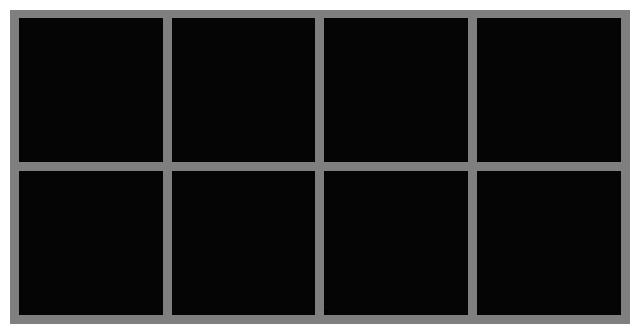

In [12]:
def generate_images(net, n_gen=8, n_steps=5):
    pred_hist = []
    step_hist = []
    with torch.no_grad():
        fixed_noise = torch.randn(n_gen, 3, 32, 32).to(device)
        x = fixed_noise
        for i in range(n_steps):
            pred = net(x)
            pred_hist.append(pred.detach().cpu())
            mix_factor = 1 / (n_steps - i)  
            x = x * (1 - mix_factor) + pred * mix_factor  
            step_hist.append(x.detach().cpu()) 
        return pred, pred_hist, step_hist

n_gen = 8 
n_steps = 5
generations, pred_hist, step_hist = generate_images(net, n_gen, n_steps)
imgs = generations.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

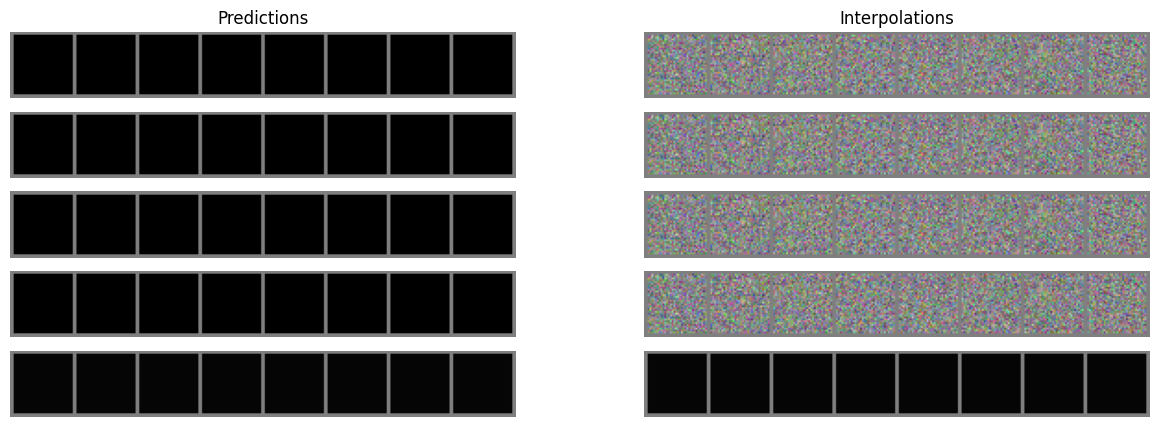

In [18]:
fig, ax = plt.subplots(n_steps, 2, figsize=(15, 5))
for i in range(n_steps):
    ax[i, 0].imshow(torchvision.utils.make_grid(pred_hist[i], normalize=True, pad_value=0.5).permute(1, 2, 0))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(torchvision.utils.make_grid(step_hist[i], normalize=True, pad_value=0.5).permute(1, 2, 0))
    ax[i, 1].axis('off')
ax[0, 0].set_title('Predictions')
ax[0, 1].set_title('Interpolations')
plt.show()